In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
# %% [markdown]
# # Advanced E-Commerce Analytics
# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

c:\Users\Sharif\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load processed data
df = pd.read_csv("Data/Processed_data.csv", parse_dates=['InvoiceDate'])

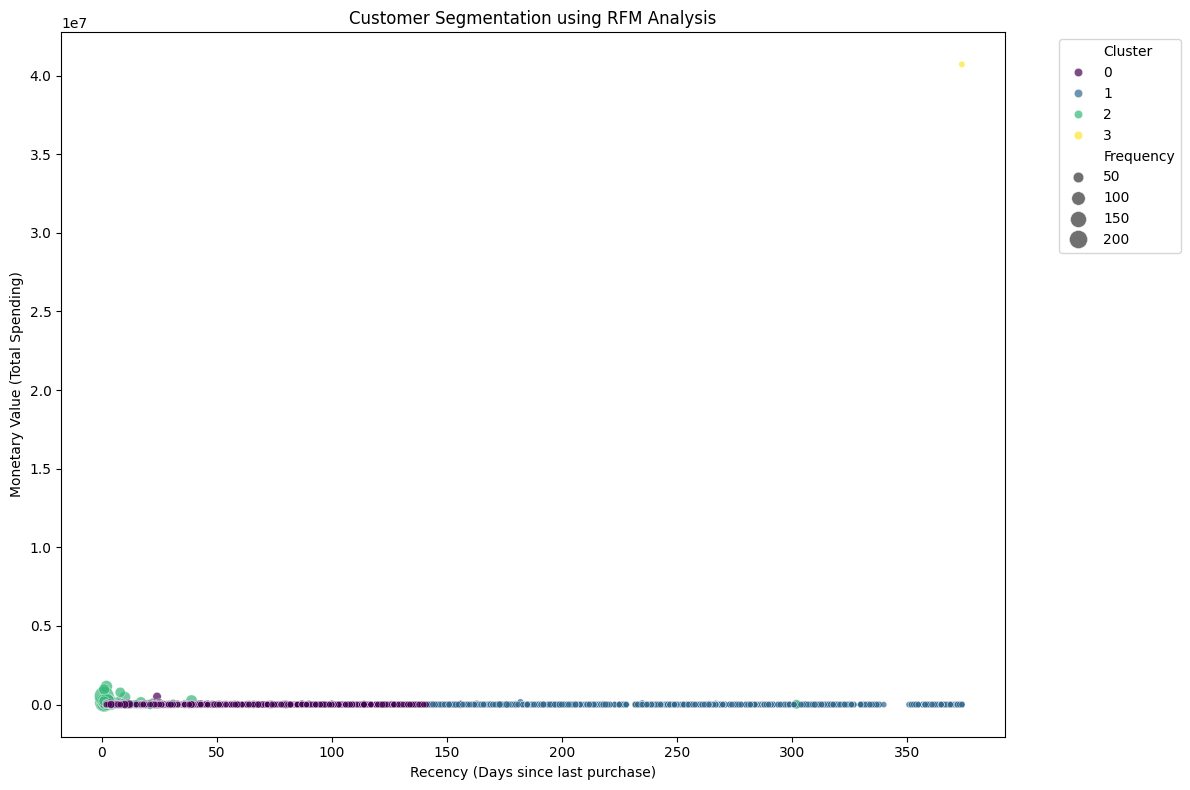

In [ ]:

ANALYSIS_DATE = df['InvoiceDate'].max() + pd.DateOffset(days=1)
N_CLUSTERS = 4

def calculate_rfm(data):
    """Calculate RFM metrics"""
    return data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (ANALYSIS_DATE - x.max()).days,
        'InvoiceNo': 'nunique',
        'Total_Spend': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'Total_Spend': 'Monetary'
    })

def cluster_customers(rfm_df):
    """Perform clustering on RFM metrics"""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(rfm_df)
    
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    rfm_df['Cluster'] = kmeans.fit_predict(scaled_data)
    return rfm_df, kmeans.cluster_centers_

# Main analysis
if __name__ == "__main__":
    rfm = calculate_rfm(df)
    rfm_clustered, cluster_centers = cluster_customers(rfm)
    
    # Visualization
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=rfm_clustered, x='Recency', y='Monetary', 
                    hue='Cluster', palette='viridis', size='Frequency',
                    sizes=(20, 200), alpha=0.7)
    plt.title('Customer Segmentation using RFM Analysis')
    plt.xlabel('Recency (Days since last purchase)')
    plt.ylabel('Monetary Value (Total Spending)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig('views/customer_segments.png', dpi=300, bbox_inches='tight')
    
    # Save clustered data
    # rfm_clustered.to_csv('Data/customer_segments.csv', index=True)

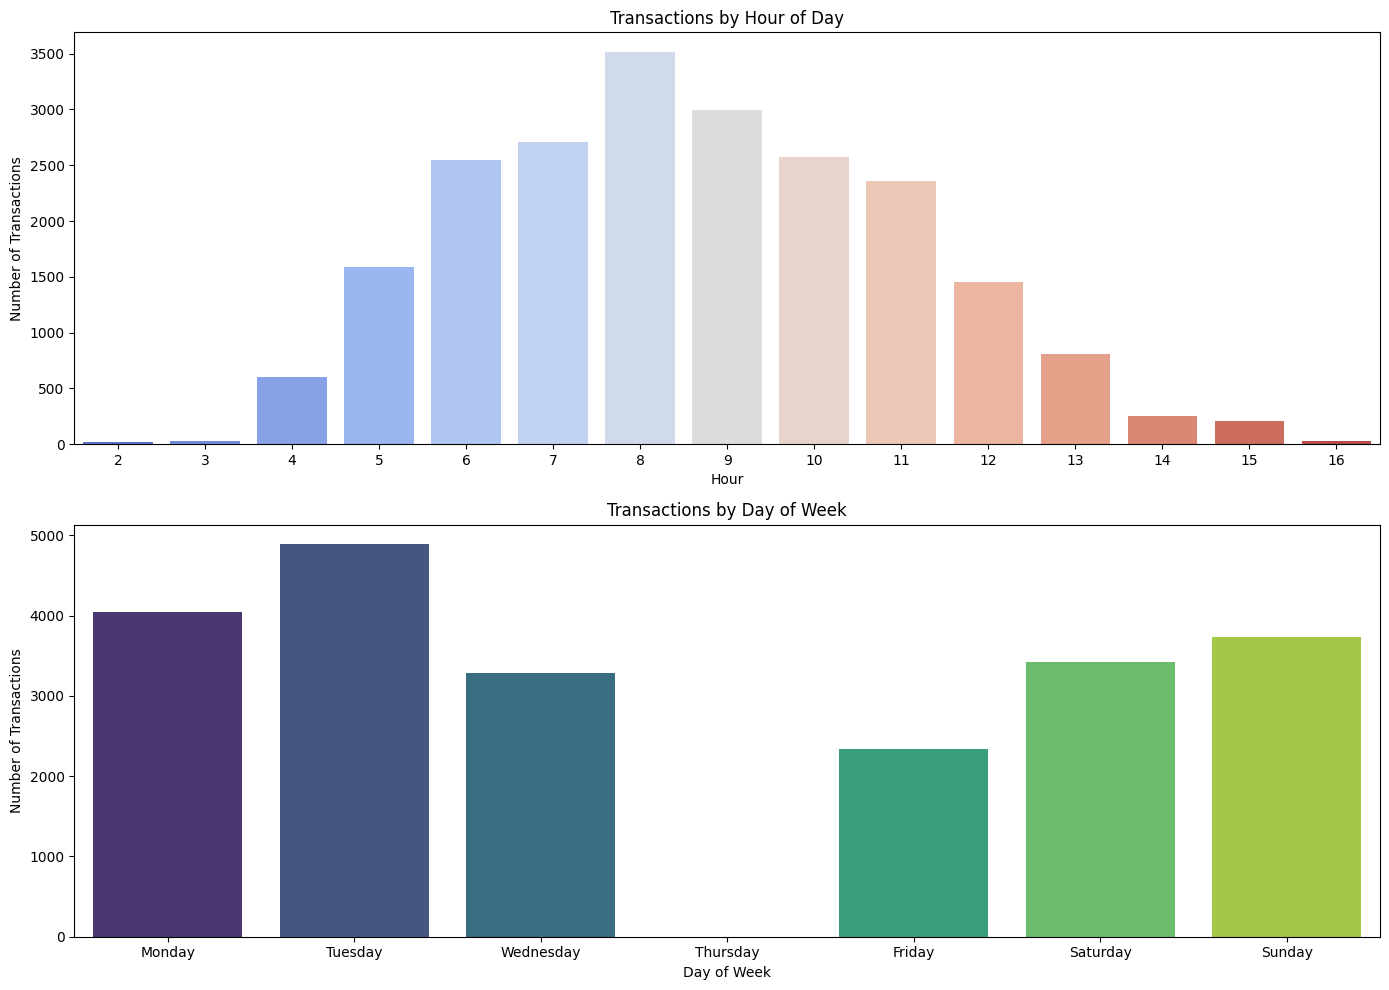

In [ ]:
# transaction_analysis.py

def load_data():
    df = pd.read_csv("Data/Processed_data.csv", parse_dates=['InvoiceDate'])
    df['Hour'] = df['InvoiceDate'].dt.hour
    df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
    return df

def plot_transaction_patterns(df):
    fig, ax = plt.subplots(2, 1, figsize=(14, 10))
    
    # Hourly pattern
    hourly = df.groupby('Hour')['InvoiceNo'].nunique()
    sns.barplot(x=hourly.index, y=hourly.values, ax=ax[0], palette='coolwarm')
    ax[0].set_title('Transactions by Hour of Day')
    ax[0].set_xlabel('Hour')
    ax[0].set_ylabel('Number of Transactions')
    
    # Weekly pattern
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly = df.groupby('DayOfWeek')['InvoiceNo'].nunique().reindex(weekday_order)
    sns.barplot(x=weekly.index, y=weekly.values, ax=ax[1], palette='viridis')
    ax[1].set_title('Transactions by Day of Week')
    ax[1].set_xlabel('Day of Week')
    ax[1].set_ylabel('Number of Transactions')
    
    plt.tight_layout()
    # plt.savefig('views/transaction_patterns.png', dpi=300)

if __name__ == "__main__":
    data = load_data()
    plot_transaction_patterns(data)

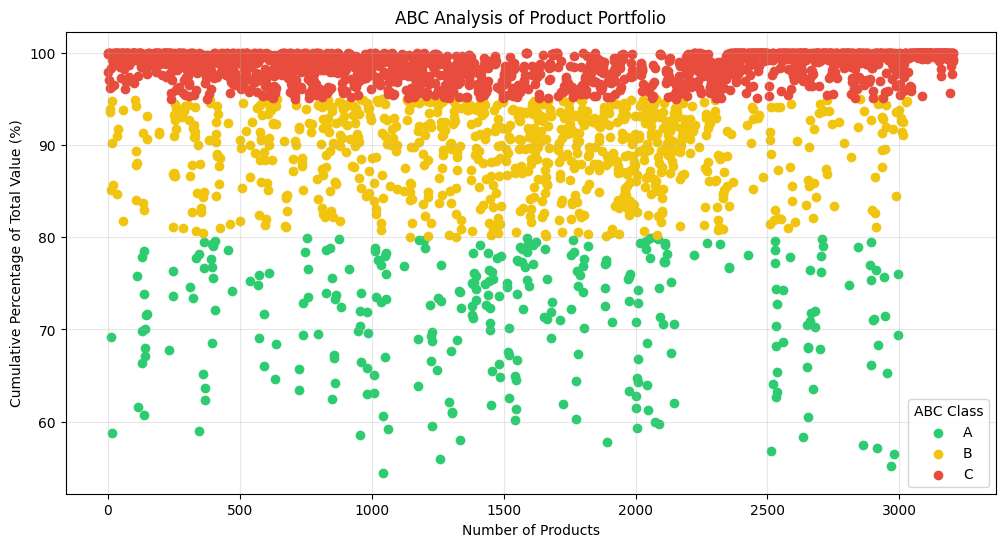

In [ ]:
# product_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def abc_classification(df):
    product_value = df.groupby('StockCode').agg({
        'Total_Spend': 'sum',
        'Quantity': 'sum'
    }).reset_index()
    
    product_value['ValuePct'] = product_value['Total_Spend'] / product_value['Total_Spend'].sum() * 100
    product_value = product_value.sort_values('ValuePct', ascending=False)
    
    product_value['CumPct'] = product_value['ValuePct'].cumsum()
    product_value['Class'] = np.where(
        product_value['CumPct'] <= 80, 'A',
        np.where(product_value['CumPct'] <= 95, 'B', 'C'))
    
    return product_value

def plot_abc_classification(df):
    plt.figure(figsize=(12, 6))
    
    for cls, color in zip(['A', 'B', 'C'], ['#2ecc71', '#f1c40f', '#e74c3c']):
        subset = df[df['Class'] == cls]
        plt.scatter(subset.index, subset['CumPct'], color=color, label=cls)
    
    plt.title('ABC Analysis of Product Portfolio')
    plt.xlabel('Number of Products')
    plt.ylabel('Cumulative Percentage of Total Value (%)')
    plt.legend(title='ABC Class')
    plt.grid(True, alpha=0.3)
    # plt.savefig('views/abc_analysis.png', dpi=300)

if __name__ == "__main__":
    df = pd.read_csv("Data/Processed_data.csv")
    product_analysis = abc_classification(df)
    plot_abc_classification(product_analysis)
    # product_analysis.to_csv('Data/product_classification.csv', index=False)

✅ Data loaded successfully
📅 Date range: 2018-02-12 to 2019-02-20
📊 Dataset shape: (398425, 14)


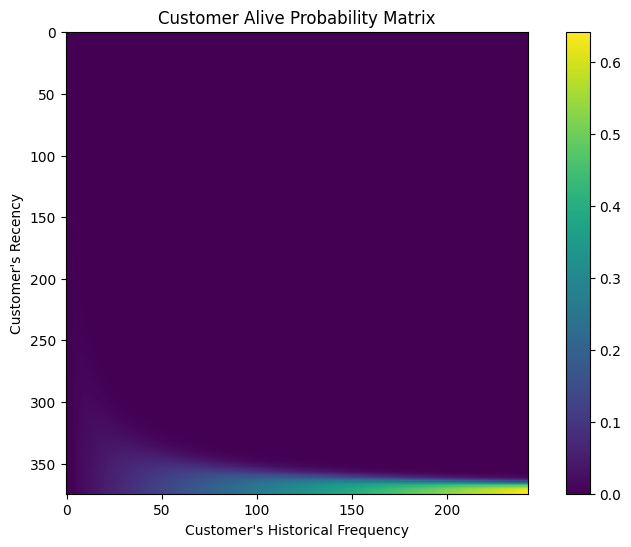

<Figure size 640x480 with 0 Axes>

In [ ]:


# %% [markdown]
# ## Data Loading & Preparation
# %%
try:
    df = pd.read_csv("Data/Processed_data.csv", parse_dates=['InvoiceDate'])
    print("✅ Data loaded successfully")
    print(f"📅 Date range: {df['InvoiceDate'].min().date()} to {df['InvoiceDate'].max().date()}")
    print(f"📊 Dataset shape: {df.shape}")
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")

# %% [markdown]
# ## 1. Customer Lifetime Value Analysis (Fixed)
# %%
# Calculate observation period correctly
current_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
df_cohort = df.groupby('CustomerID')['InvoiceDate'].agg(['min', 'max'])
df_cohort['T'] = (current_date - df_cohort['min']).dt.days
df_cohort['recency'] = (current_date - df_cohort['max']).dt.days
df_cohort['frequency'] = df.groupby('CustomerID')['InvoiceNo'].nunique()
df_cohort['monetary'] = df.groupby('CustomerID')['Total_Spend'].mean()

# Filter valid customers
rfm = df_cohort[(df_cohort['frequency'] > 0) & (df_cohort['monetary'] > 0)]

# Fit model
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(rfm['frequency'], rfm['recency'], rfm['T'])

# Visualization
plt.figure(figsize=(10, 6))
plot_frequency_recency_matrix(bgf)
plt.title('Customer Alive Probability Matrix')
plt.show()
# plt.savefig('views/clv_matrix.png', dpi=300)


01:13:42 - cmdstanpy - INFO - Chain [1] start processing
01:13:42 - cmdstanpy - INFO - Chain [1] done processing


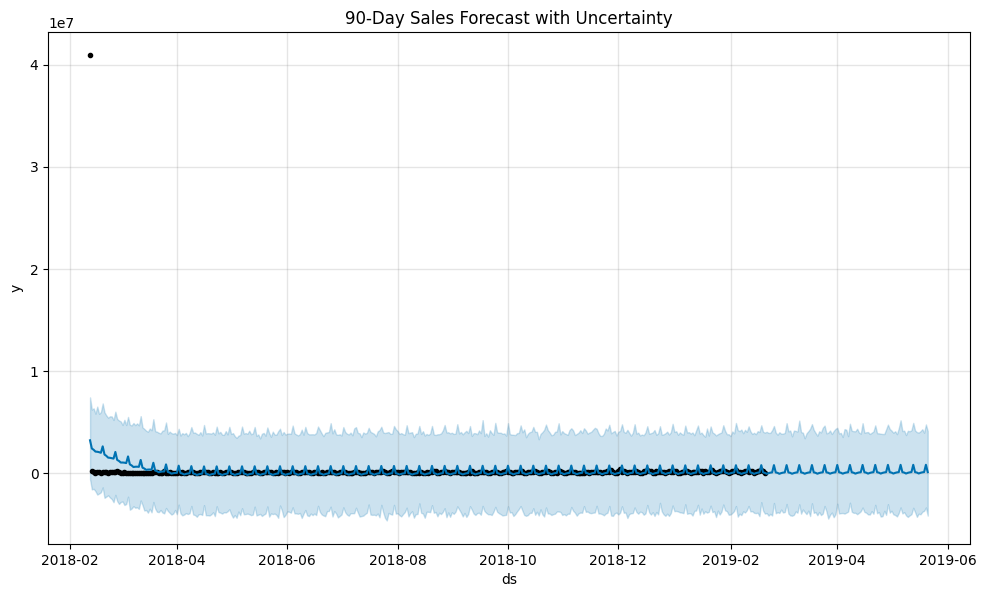

<Figure size 640x480 with 0 Axes>

In [ ]:

# %% [markdown]
# ## 2. Sales Forecasting with Prophet
# %%
daily_sales = df.resample('D', on='InvoiceDate')['Total_Spend'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

model = Prophet(interval_width=0.95)
model.fit(daily_sales)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('90-Day Sales Forecast with Uncertainty')
plt.show()
# plt.savefig('views/sales_forecast.png', dpi=300)


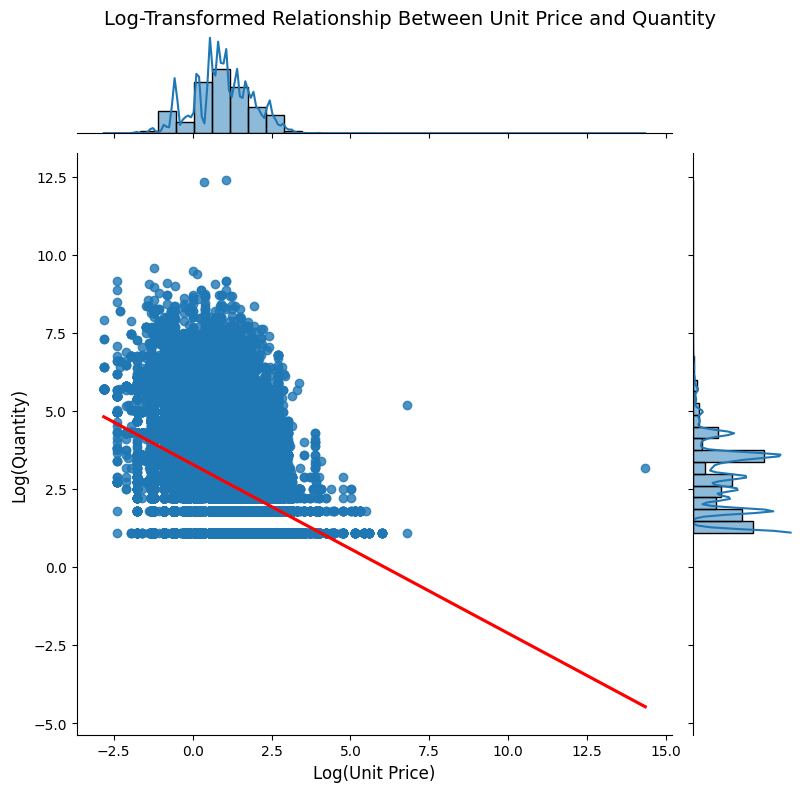

In [12]:

# %% [markdown]
# ## 3. Price Elasticity Analysis
# %%

# Log-transform and drop NaNs or infs if necessary
log_price = np.log(df['UnitPrice'].replace(0, np.nan)).dropna()
log_qty = np.log(df['Quantity'].replace(0, np.nan)).dropna()
valid_idx = log_price.index.intersection(log_qty.index)

# Create the jointplot
g = sns.jointplot(
    x=log_price.loc[valid_idx],
    y=log_qty.loc[valid_idx],
    kind='reg',
    height=8,
    joint_kws={'line_kws': {'color': 'red'}},
    marginal_kws={'bins': 30, 'fill': True}
)

# Set axis labels
g.set_axis_labels("Log(Unit Price)", "Log(Quantity)", fontsize=12)

# Add a clear title
plt.subplots_adjust(top=0.95)
g.fig.suptitle("Log-Transformed Relationship Between Unit Price and Quantity", fontsize=14)

plt.show()

# plt.savefig('views/price_elasticity.png', dpi=300)


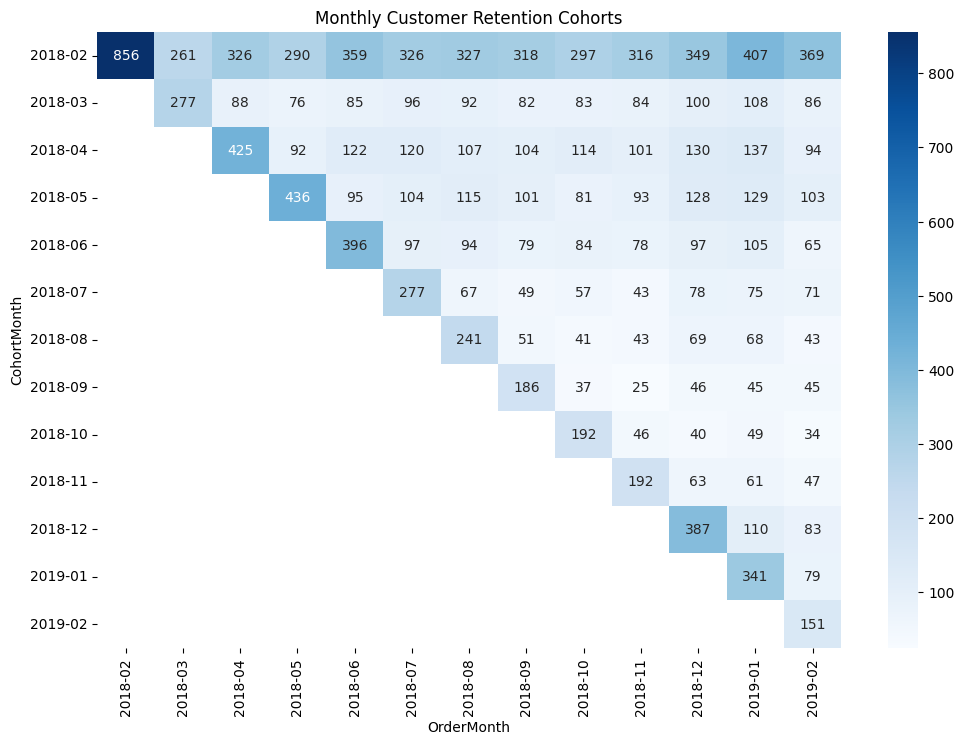

<Figure size 640x480 with 0 Axes>

In [ ]:

# %% [markdown]
# ## 4. Customer Cohort Analysis
# %%
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df['OrderMonth'] = df['InvoiceDate'].dt.to_period('M')

cohort_data = df.groupby(['CohortMonth', 'OrderMonth']) \
              .agg(n_customers=('CustomerID', 'nunique')) \
              .reset_index()

cohort_pivot = cohort_data.pivot_table(index='CohortMonth',
                                     columns='OrderMonth',
                                     values='n_customers')

plt.figure(figsize=(12, 8))
sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Monthly Customer Retention Cohorts')
plt.show()
# plt.savefig('views/cohort_analysis.png', dpi=300)


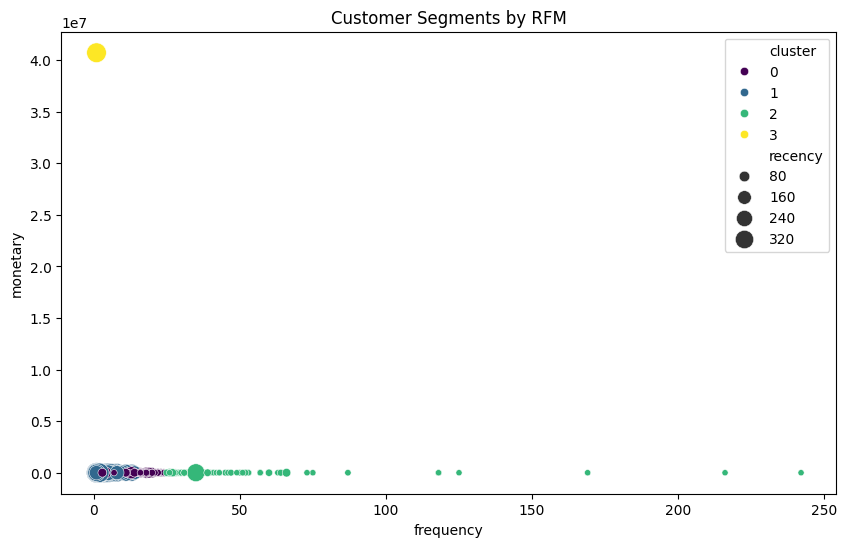

<Figure size 640x480 with 0 Axes>

In [ ]:

# %% [markdown]
# ## 5. Customer Segmentation
# %%
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', hue='cluster', 
                data=rfm, palette='viridis', size='recency',
                sizes=(20, 200))
plt.title('Customer Segments by RFM')
plt.show()
# plt.savefig('views/customer_segments.png', dpi=300)


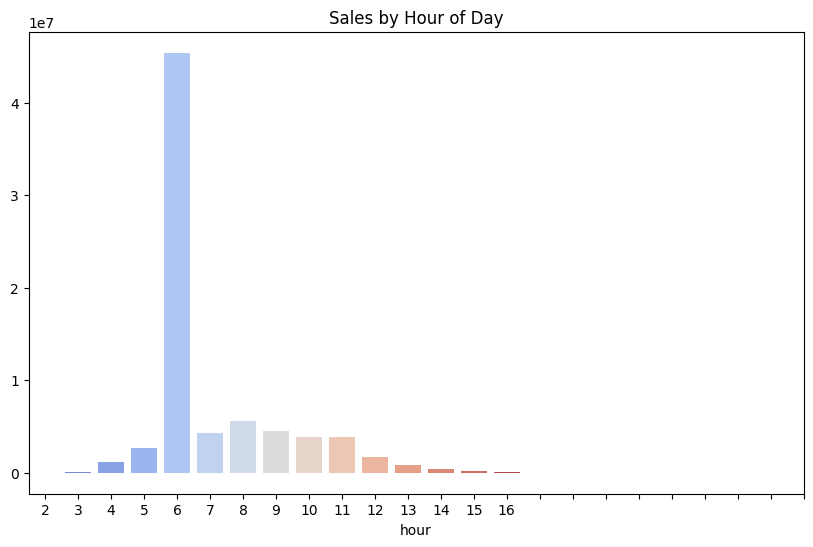

<Figure size 640x480 with 0 Axes>

In [ ]:

# %% [markdown]
# ## 6. Time-of-Day Analysis
# %%
df['hour'] = df['InvoiceDate'].dt.hour
hourly_sales = df.groupby('hour')['Total_Spend'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, palette='coolwarm')
plt.title('Sales by Hour of Day')
plt.xticks(range(0, 24))
plt.show()
# plt.savefig('views/hourly_sales.png', dpi=300)